In [1]:
# Purpose: Preparing the perturbation forcing for the tropics simulation
#          i.e. climatological forcing everywhere, except over the +/-25°N/S
#          tropics with tapering off across 5° latitude at each side from
#          sin(pi/2) to sin(pi)
#          -> only doing it for surface air temperature (SAT) for now
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 11. 05. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps                                                                   
import os.path # to check if file exists
from matplotlib import gridspec
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.mpl.ticker as cticker
from matplotlib import ticker

import cartopy.feature as cfeature

import nc_time_axis
import cftime

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
ned_blue = [.12,.27,.54] # blue colour from the Dutch flag                                              
ned_red  = [.68,.10,.15] # red  "    "    "    "    "    "
myblue = [.19, .21, .58]

from dask.distributed import Client
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:34649 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


In [2]:
%%time
# load JRA55-do data and create the masks
# climatological mask = everywhere 1962-1972 data except the tropics where there are zero values
# tropics mask = 1972-2018 data only in the tropics with zero values everywhere else

base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/atmos/3hrPt/tas/gr/v20190429/'
fname = 'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'

#a = np.linspace(1958,2017,60) # years 1958, 1959, 1960, ..., 2017
a = np.linspace(1958,1958,1)

for year in a:                 # loop over all years
    year = str(int(year))
    ds1 = xr.open_mfdataset(base + fname + year + '*',combine = 'by_coords', chunks = {'time': 1},decode_times = True) # open dataset
#    ds2 = xr.open_mfdataset(base + fname + '2017*',combine = 'by_coords', chunks = {'time': 1},decode_times = True) # open dataset

ds = ds1.tas[1,:,:] # plot everywhere zero values except over land where we have nan
ds = ds.where(np.isnan(ds),0)

# now the next step is tapering from np.sin(pi) to np.sin(0)
smoothing = [1, 0.8, 0.6, 0.4, .2, 0]

u = ds.where((ds.lat>46) | (ds.lat<-46) | np.isnan(ds), smoothing[5]) 
u = u.where((u.lat>45) | (u.lat<-45) | np.isnan(u),smoothing[4]) 
u = u.where((u.lat>44) | (u.lat<-44) | np.isnan(u),smoothing[3])
u = u.where((u.lat>43) | (u.lat<-43) | np.isnan(u),smoothing[2])
u = u.where((u.lat>42) | (u.lat<-42) | np.isnan(u),smoothing[1])
u = u.where((u.lat>41) | (u.lat<-41) | np.isnan(u),smoothing[0])
iaf_mask = u.where((u.lat>40) | (u.lat<-40),1)
#iaf_mask.plot()

# save to netcdf
#iaf_mask.to_netcdf(save + 'basin_mask_tropics_pert.nc', encoding=tropics.encoding.update({'zlib': True, 'complevel': 4}))

# next step, do the oppsoite for the climatological part of the forcing
# it needs to be 1 everywhere, except in the tropics and tapering from zero to 1 to the 25° latitude border with the tropics

ds = ds1.tas[1,:,:]
ds = ds.where(np.isnan(ds),1) # plot everywhere zero values except over land where we have nan

u = ds.where((ds.lat>46) | (ds.lat<-46) | np.isnan(ds),smoothing[0]) 
u = u.where((u.lat>45) | (u.lat<-45) | np.isnan(u),smoothing[1])
u = u.where((u.lat>44) | (u.lat<-44) | np.isnan(u),smoothing[2])
u = u.where((u.lat>43) | (u.lat<-43) | np.isnan(u),smoothing[3])
u = u.where((u.lat>42) | (u.lat<-42) | np.isnan(u),smoothing[4])
u = u.where((u.lat>41) | (u.lat<-41) | np.isnan(u),smoothing[5])
rdf_mask = u.where((u.lat>40) | (u.lat<-40) | np.isnan(u),0)


# save back into xarray structure and save as .netcdf file  
ds3 = xr.Dataset({'tas': ds, 
                  'iaf_mask_tropics': (('lat', 'lon'), iaf_mask),
                  'iaf_mask_extratropics': (('lat', 'lon'), rdf_mask)}) 


os.system('rm -r /g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_tropics_extratropics_runs.nc')
ds3.to_netcdf('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_tropics_extratropics_runs.nc') 


CPU times: user 411 ms, sys: 154 ms, total: 565 ms
Wall time: 3.69 s


### Plotting routine for masks

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/ipykernel_launcher.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


CPU times: user 2.94 s, sys: 139 ms, total: 3.08 s
Wall time: 3.02 s


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.04/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


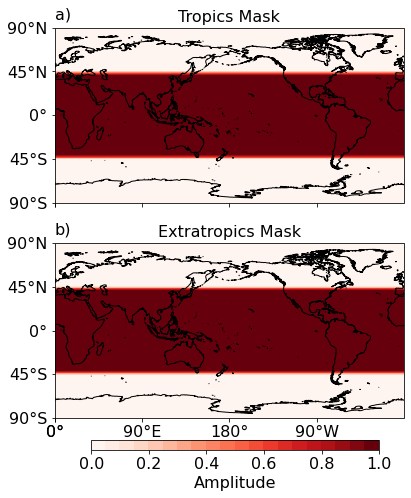

In [5]:
%%time
ds3 = xr.open_dataset('/g/data/e14/mv7494/HeatDist_input/JRA55-do_basin_masks_for_tropics_extratropics_runs.nc')  
plot_range=[-90,90]; ticks = np.linspace(0,1,21)
# initialise figure
fig = plt.figure(figsize=(16, 9),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(3,1) 
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-90,-45,0,45,90], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False);axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

# --- Tropics ---------------------------------------------------------- #
ax1 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p2 = ds3.iaf_mask_tropics.plot.contourf(levels=ticks, cmap='Reds',
                                 add_colorbar=False,extend='neither',transform=ccrs.PlateCarree())

plt.title('Tropics Mask', fontsize=16) # title
ax1.text(0, 1.05,string.ascii_lowercase[0]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
fancy_plot(ax1); ax1.set_xticklabels([], minor=False)

# --- Extratropics -------------------------------------------------------- #
ax1 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p2 = ds3.iaf_mask_tropics.plot.contourf(levels=ticks, cmap='Reds',
                                 add_colorbar=False,extend='neither',transform=ccrs.PlateCarree())

plt.title('Extratropics Mask', fontsize=16) # title
ax1.text(0, 1.05,string.ascii_lowercase[1]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
fancy_plot(ax1)

# # --- Tropics -------------------------------------------------------- #
# ax1 = plt.subplot(gs[2,0], projection=ccrs.PlateCarree(central_longitude=0))
# ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

# #p2 = iaf_mask.plot.contourf(levels=ticks, cmap='Reds',
# #                                 add_colorbar=False,extend='neither',transform=ccrs.PlateCarree())

# plt.title('No Mask', fontsize=16) # title
# ax1.text(0, 1.05,string.ascii_lowercase[2]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
# fancy_plot(ax1); ax1.set_yticklabels([], minor=False)

# add colour bar
cax = fig.add_axes([0.38, 0.3, 0.25, 0.015]) # position: [x0, y0, width, height]
cb = plt.colorbar(p2, cax = cax, shrink=.25, orientation='horizontal'); 
cb.set_label(label='Amplitude', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=6)
cb.locator = tick_locator;cb.update_ticks()  


# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'JRA55_basin_mask_preparation_for_forcing_tropics', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #

# Wall time: 52.3 s

### Here the heavy lifting: combine masks with IAF and RDF forcing and save in specified folder
##### -> (IAF data * iaf_mask) + (RDF data * rdf_mask)

In [6]:
# combining RDF and IAF forcing into a netcdf file

# --- which forcing to use, either JRA55-do-1-3 or JRA55-do-1-4-0
forcing = '1-3'


# to accommodate the different forcing which has different naming conventions
if forcing == '1-3':
    base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/'
    fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_' 
    version = 'gn/v20180412/'
    hrPt_timestep = ['01010000','12312230']
    hr_timestep = ['01010130','01010000']
    day_timestep = ['0101','0101']
    experiment = 'EXP_tropics_40SN_JRA55-do-1-3/'
elif forcing == '1-4-0':
    base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-4-0/'
    fname = '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-4-0_gr_'
    version = 'gr/v20190429/'
    hrPt_timestep = ['01010000','12312100']
    hr_timestep = ['01010130','12312230']
    day_timestep = ['0101','1231']
    experiment = 'EXP_tropics_40SN_JRA55-do-1-4-0/'   
      
# variables of the JRA55 input
# friver = water flux into sea water from rivers          # rlds = surface downwelling longwave radiation
# huss =  near-surface specific humidity                  # rsds = surface downwelling shortwave radiation
# licalvf = land ice calving flux                         # tas = near-surface air temperature
# prra = rainfall flux                                    # uas = eastward near-surface wind
# prsn = snowfall flux                                    # vas = northward near-surface wind
# psl = sea level pressure 

#var = ['friver','huss','licalvf,','prra','prsn','psl','rlds','rsds','tas','uas','vas'] # full list of input variables

var = ['uas','vas','tas','huss','rlds','rsds','prra','psl','prsn']#,'friver'] # only eight of the variables I used in my Msc


a = np.linspace(1972,2018,47) # years 1958, 1959, 1960, ..., 2017


# repeating the 1962-1971 period 4.6 times to build one repeating list
b = np.linspace(1962,1971,10)
b = np.concatenate((b, b, b, b, [1962,1963,1964,1965,1966,1967]), axis=0)

# ok, this is great. Now I have two lists, one cycling through the 1962-1971 climatological period and the other going
# from 1972-2018 with the IAF perturbation in the tropics

# testing
#dp(a)
#dp(b)

startTime = datetime.now() # start clock     

for i in range(0,10):                 # loop over the JRA55 variables,          range(0,10):
    for year in range(0,46):          # loop over all years from 1972-2018,    range(0,46):
        year_a = str(int(a[year]))
        year_aa = str(int(a[year+1]))
        year_b = str(int(b[year]))       
        startTime = datetime.now()   # start clock     

        # get correct subfolder, either 'atmos', 'land' or 'landIce'
        if var[i] == 'friver' and forcing == '1-3':
            domain = 'ocean/'
        elif var[i] == 'friver' and forcing == '1-4-0':
            domain = 'land/'
        elif var[i] == 'licalvf':
            domain = 'landIce/'
        else:
            domain = 'atmos/'
        
        # get correct resolution of forcing field, either '3hr', '3hrPt' or 'day'
        if var[i] in ['rsds','rlds','prra','prsn']:
            res = '3hr/'
        elif var[i] in ['psl','tas','huss','uas','vas']:
            res = '3hrPt/'
        else:
            res = 'day/'
            
        # load in data for interannual IAF forcing 
        ds1 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_a + '*',combine = 'by_coords', 
                                chunks = {'time': 1},decode_times = True) # open dataset  
        #ds1 = ds1.sel(time = year_a + '-01-01') # only select subset of data
    

        # load in data for climatological RDF forcing 
        ds2 = xr.open_mfdataset(base + domain + res + var[i] + '/' + version + var[i] + fname + year_b + '*',combine = 'by_coords', 
                                chunks = {'time': 1},decode_times = True) # open dataset
        

        # leap day adjustment, either add or remove 29th of Feb. so the clim. and IAF forcing match
        # the adjustment takes place in the ds2, i.e. climatological data
        # see also file presentation20200511.ppt in the autumn semester 2020 folder
        if year_a in ['1972','1976','1980','1992','1996','2000','2012', '2016']:
            # in these yeas I have to add a leap day in the clim. files as a copy of 28th of Feb
            #print(year_b)  

            # --- in this section I add a leap day

            new_attrs = {**ds2.time.attrs} # keep the time attributes for later use
            day_length=ds2.time.size//365 # day_length = 8, 6-hourly data

            # extract the 28th of February
            ds2_29 = ds2.isel(time=slice((31+27)*day_length,(31+28)*day_length)) 

            # day_shift is 1 as the unit of the time array is day here.
            # But it could be more if time was in hours for example.
            # See the time attributes for the unit.
            day_shift = ds2.time.values[day_length] - ds2.time.values[0] 
            ds2_29.time.values[:] += day_shift

            # Create a 1 day "hole" in original time coordinate:
            ds2.time.values[-day_length:] += day_shift

            ds2 = xr.concat((ds2,ds2_29),dim="time") # yes, great now the time vector has 2928 entries instead of 2920 (no leap days)

            # We see the result isn't quite right as the time dimension isn't ordered. Just need a sort:
            ds2 = ds2.sortby(ds2.time)

            # Now we change the calendar to all_leap and decode the times:
            new_attrs["calendar"] = "all_leap"
            time = ds2.time
            time = time.assign_attrs(**new_attrs)
            ds2 =ds2.assign_coords({"time":time})

            print('Year ' + year_a + ' & ' + var[i] + ': leap day added')   
            
        elif year_a in ['1974', '1978', '1994', '1998', '2014']:
            # in these yeas I have to remove the leap day in the clim. files 
            ds2 = ds2.sel(time=~((ds2.time.dt.month == 2) & (ds2.time.dt.day == 29)))
            print('Year ' + year_a + ' & ' + var[i] + ': leap day deleted')   
        else:
            print('Year ' + year_a + ' & ' + var[i] + ': no adjustment')   
        ds2['time'] = ds1.time # overwrite time vector so that the 'interannual' and 'climatological' regions have the same time vector

        # iaf_mask has IAF forcing in the tropics and zeroes in the extratropics
        # rdf_mask has RDF forcing in the extratropics and zeroes in the tropics
        # --------------------------------------------------------------------------------------------------- #
        ds1[var[i]] = (ds1[var[i]] * iaf_mask) + (ds2[var[i]] * rdf_mask) # combine the masks with the actual forcing
        # --------------------------------------------------------------------------------------------------- #     

        # different file names depending on the variables
        if var[i] in ['uas','vas','tas','psl','huss']:
            # construct filename for output file, e.g.
            # filename = '/g/data/e14/mv7494/HeatDist_input/EXP_tropics_JRA55-do-1-3//uas/uas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_197201010000-12312230.nc'
            filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hrPt_timestep[0] + '-' + year_a + hrPt_timestep[1] + '.nc'
            if os.path.isfile(filename) == True: # check if file already exists, if yes then I can skip that iteration which speeds up my script
                continue                
            else: 
                ds1.to_netcdf(filename) # if file not yet exists, save array to netcdf file
        elif var[i] in ['prra','prsn','rlds','rsds']:
            filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i] + '/' + var[i] + fname + year_a + hr_timestep[0] + '-' + year_aa + hr_timestep[1] + '.nc'
            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)
        elif var[i] == 'friver':
            if forcing == '1-3':
                filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_aa + day_timestep[1] + '.nc'
            else:
                filename = '/g/data/e14/mv7494/HeatDist_input/' + experiment + var[i]+ '/' + var[i] + fname + year_a + day_timestep[0] + '-' + year_a + day_timestep[1] + '.nc'

            if os.path.isfile(filename) == True:
                continue
            else: 
                ds1.to_netcdf(filename)

        # ok this works, but is missing the lat/lon/bnds fields

        print(datetime.now() - startTime) # end time of script
        print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')    
        print('') 
    # Note: Saving one month of data takes 18 seconds
    # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    print('#########################################')    
    print('#           Variable finished           #')
    print('#########################################')    
    print('') 
    
    # it works!!! takes 0:01:08.35 seconds for one variable and for one year using 48 cores and 24 workers

Year 1972 & uas: leap day added
0:01:18.049533
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Year 1973 & uas: no adjustment
0:00:59.702119
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#########################################
#           Variable finished           #
#########################################

Year 1972 & vas: leap day added
0:01:27.230224
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Year 1973 & vas: no adjustment
0:00:57.148540
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#########################################
#           Variable finished           #
#########################################

Year 1972 & tas: leap day added
0:01:03.644476
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Year 1973 & tas: no adjustment
0:01:07.659469
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#########################################
#           Variable finished           #
#########################################

Year 1972 & huss: leap day added
0:01:09.755565
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

IndexError: list index out of range

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #